<a href="https://colab.research.google.com/github/frogbysachs/LASA-Data-Science/blob/Unit-4/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
cs_data

,ID,aa,theo,exp,cat
0,1BM8,ILE,61.18,58.27,Non-Polar
1,1BM8,TYR,56.95,56.18,Polar
2,1BM8,SER,56.35,56.84,Polar
3,1BM8,ALA,51.96,51.01,Special
4,1BM8,ARG,56.54,54.64,Charged
...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged
1772,1KS9,ARG,58.91,59.02,Charged
1773,1KS9,LYS,59.49,58.92,Charged
1774,1KS9,GLU,59.48,58.36,Charged


In [3]:
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


In [4]:
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [5]:
with pm.Model(coords=aa_coords) as cs_h_model1:
 # hyperpriors. Notice how there's no dims argument.
  #this means that the hyperprior is shared across all amino acids
  μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
  μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
  μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

  σ = pm.HalfNormal('σ', sigma = 10,
                    dims = "aa")

    #likelihood; same as before
  y = pm.Normal('y',
                mu = μ[aa_idx],
                sigma = σ[aa_idx],
                observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
  idata_cs_h1 = pm.sample()

Output()

Output()

In [6]:
with pm.Model(coords=aa_coords) as cs_h_model:
  #Nu hyperpriors
  Nnu = 0.2
  Nsig = 10

  #Mu hyperpriors
  Mnu = pm.Exponential('Mnu', lam = 1/30)
  Mmu = pm.StudentT('Mmu', nu = 0.2, mu = 0, sigma = 10)
  Msig = pm.HalfStudentT('Msig', nu = 0.2, sigma = 10)

  #Sigma hyperpriors
  Snu = 0.2
  Ssig = 10

  #Priors
  Nu = pm.Exponential('Nu', lam = 1/30, dims = 'aa')
  Mu = pm.StudentT('Mu', nu = Mnu, mu = Mmu, sigma = Msig, dims = 'aa')
  Sigma = pm.HalfStudentT('Sigma', nu = Snu, sigma = Ssig, dims = 'aa')

  y = pm.StudentT('y', nu = Nu[aa_idx], mu = Mu[aa_idx], sigma = Sigma[aa_idx], observed = cs_data.diff_TminusE)
  idata_cs_h = pm.sample()

Output()

Output()

In [7]:
idata_cs_h

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

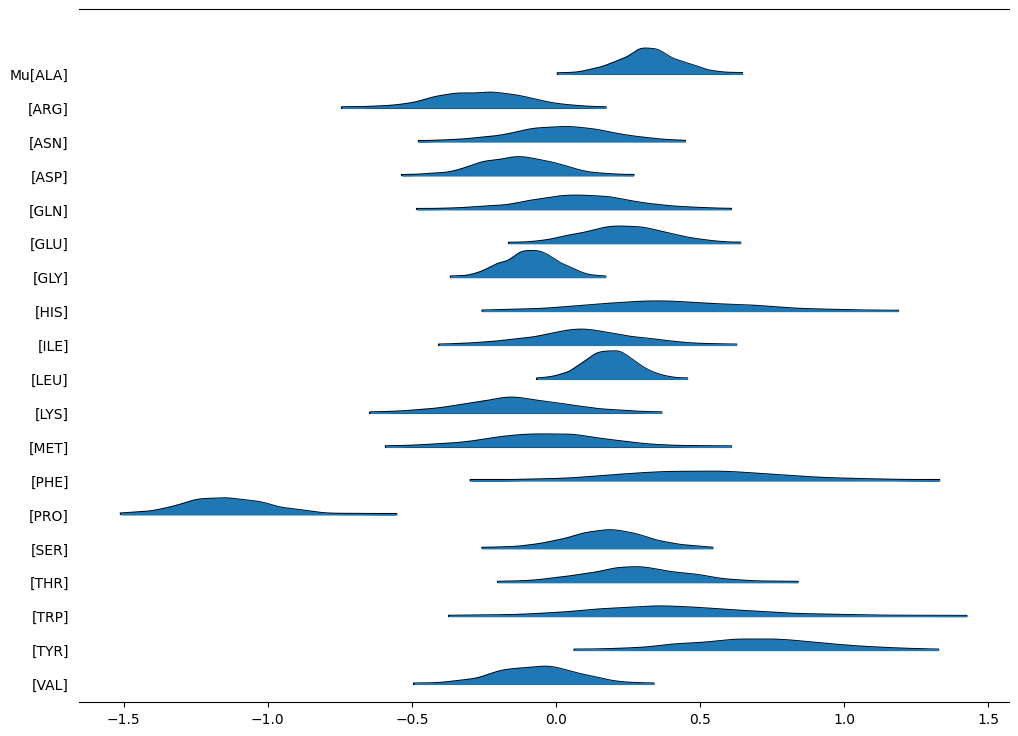

In [8]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='Mu',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

Output()

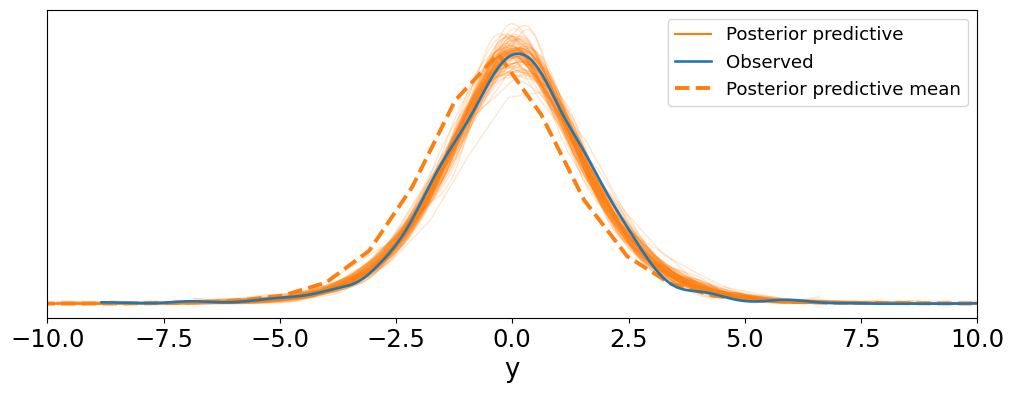

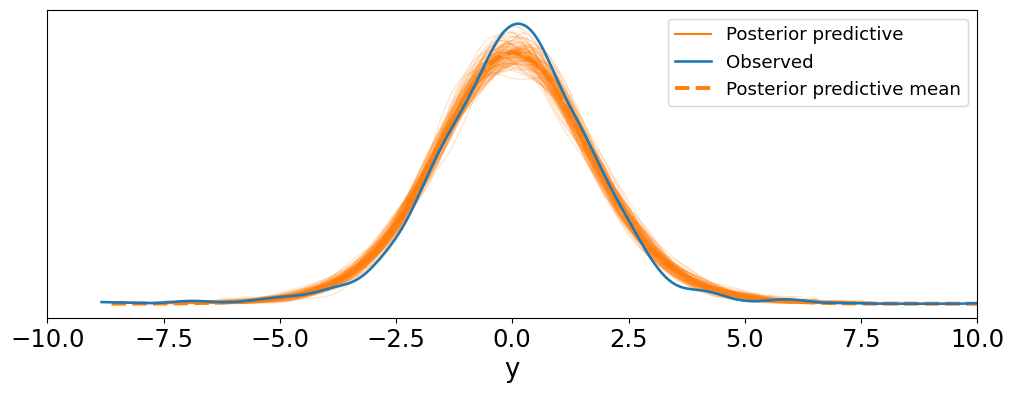

In [9]:
#ppc for the ST and HST models
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set_xbound(lower=-10, upper=10)

#ppc for the original model
pm.sample_posterior_predictive(idata_cs_h1, model=cs_h_model1, extend_inferencedata=True)
az.plot_ppc(idata_cs_h1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]).set_xbound(lower=-10, upper=10)

It looks like the top graph is a better fit for the data- that one is the one using StudentT and HalfStudentT models! So our redo is better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [10]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [11]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [12]:
with pm.Model(coords = sccr_coords) as sccr_modelNH:
    # Hyper parameters
    #
    μ = 0.08
    ν = 2500

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrNH = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

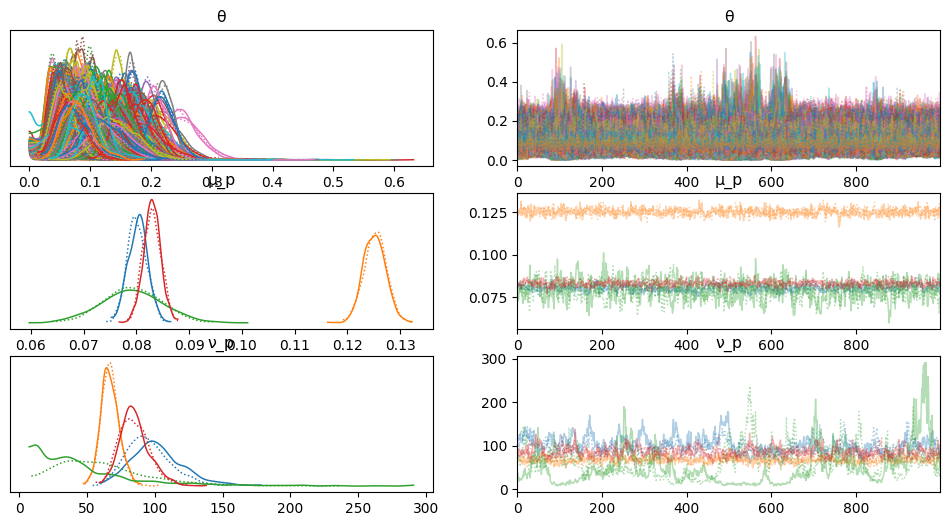

In [13]:
az.plot_trace(idata_sccrNH)

In [14]:
az.rhat(idata_sccrNH)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.002 1.001 1.0 1.003 ... 1.003 1.006 1.001
    μ_p      (pos) float64 32B 1.002 1.002 1.008 1.001
    ν_p      (pos) float64 32B 1.136 1.002 1.078 1.006

In [25]:
with pm.Model(coords = sccr_coords) as sccr_modelH:
    # Hyper parameters
    #
    mu = pm.Beta('mu', alpha = 2, beta = 20)
    nu = pm.Gamma('nu', mu = 55, sigma = 45)


    # Parameters for positions
    mu_p = pm.Beta('mu_p', mu = mu, nu = nu, dims = "pos")

    nu_p = pm.Gamma('nu_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    theta = pm.Beta('theta', mu = mu_p[pos_idx], nu = nu_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = theta, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccrH = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

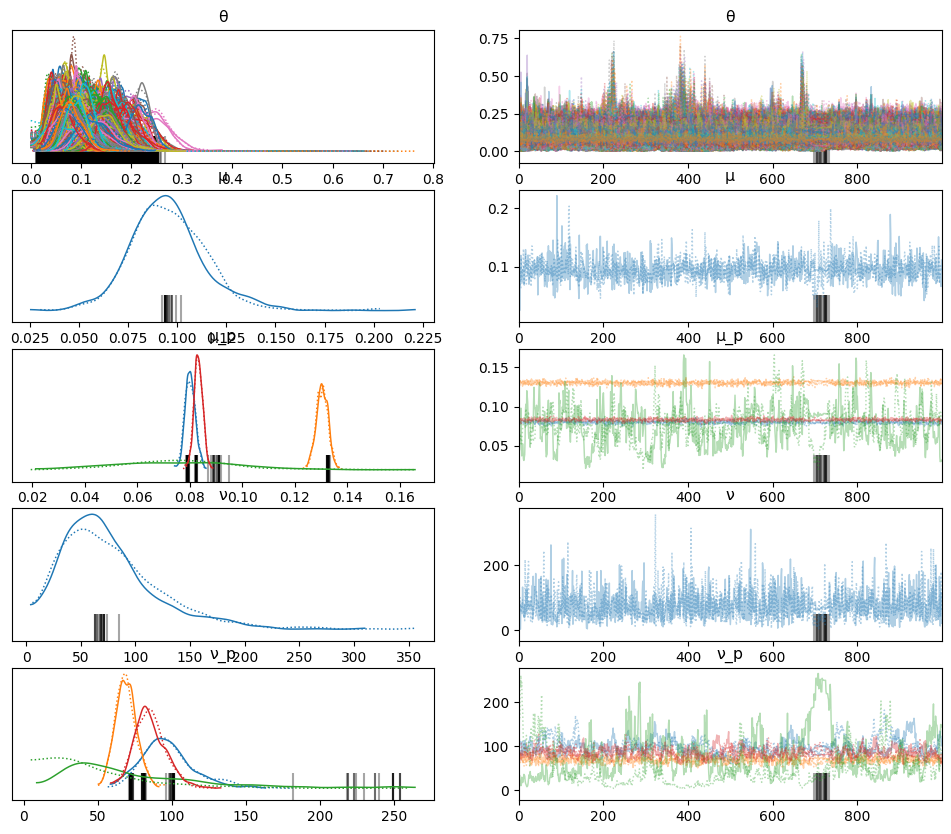

In [16]:
az.plot_trace(idata_sccrH)

In [17]:
az.rhat(idata_sccrH)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.009 1.006 1.006 1.005 ... 1.0 1.002 1.005
    μ        float64 8B 1.0
    μ_p      (pos) float64 32B 1.004 1.003 1.02 1.0
    ν        float64 8B 1.004
    ν_p      (pos) float64 32B 1.002 1.001 1.132 1.002

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

<Axes: title={'center': 'μ_p'}>

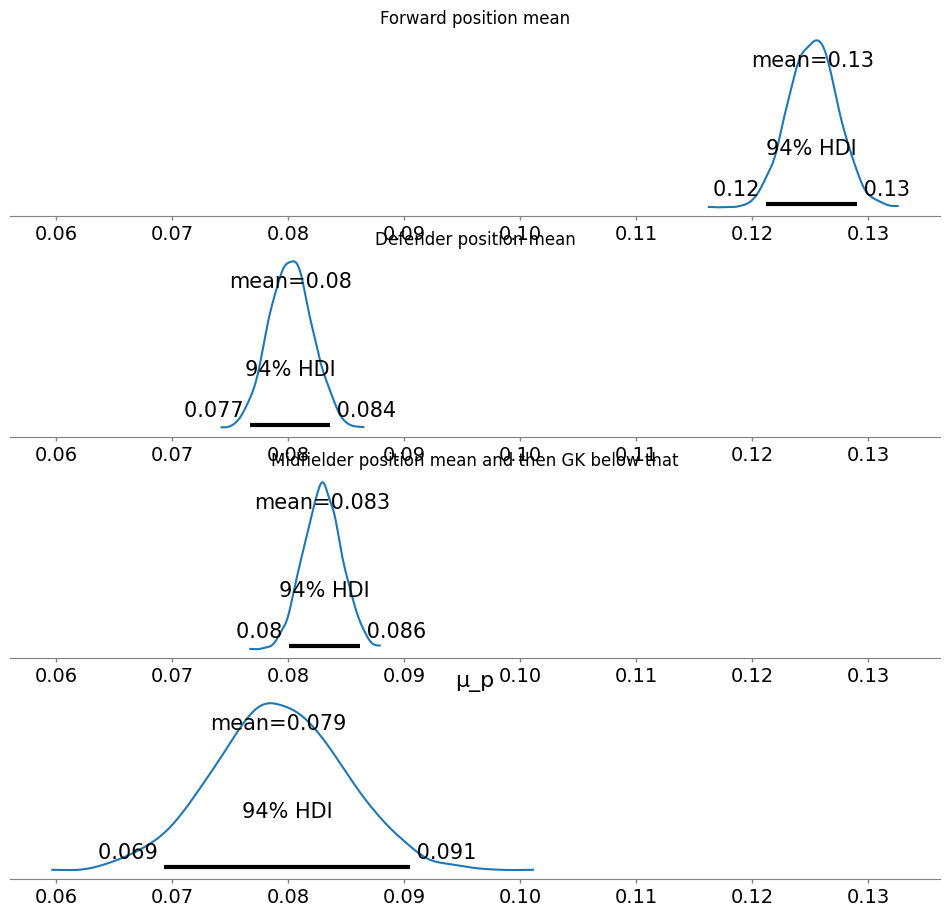

In [32]:
#preps a plot object to have 4 seperate plots, all with the same x axis
_, ax = plt.subplots(4, 1, figsize=(12, 11), sharex=True)

#plot the fowrads shooting percentage
az.plot_posterior(idata_sccrNH.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[0])
ax[0].set_title(r"Forward position mean")

#plot defender's shooting pecentage
az.plot_posterior(idata_sccrNH.posterior.sel(pos="DF"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Defender position mean")

#plot midfielders shooting percentage
az.plot_posterior(idata_sccrNH.posterior.sel(pos="MF"), var_names='μ_p', ax=ax[2])
ax[2].set_title(r"Midfielder position mean and then GK below that")

#plot goalies shooting percentage
az.plot_posterior(idata_sccrNH.posterior.sel(pos="GK"), var_names='μ_p', ax=ax[3])

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [35]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
new_data = pd.read_csv(url_sccr,dtype={'position':'category'})
new_data = new_data[new_data['position'] != 'GK']
#above removes GK as a position and below removes it as a category

new_data.position = new_data.position.cat.remove_unused_categories()
new_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


In [36]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos2_idx = new_data.position.cat.codes.values

#an array of the four strings that represent position
pos2_codes = new_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr2_coords = {"pos": pos2_codes}

In [37]:
with pm.Model(coords = sccr2_coords) as new_modelH:
    # Hyper parameters
    #
    Mu = pm.Beta('Mu', alpha = 2, beta = 20)
    Nu = pm.Gamma('Nu', mu = 55, sigma = 45)


    # Parameters for positions
    Mu_p = pm.Beta('Mu_p', mu = Mu, nu = Nu, dims = "pos")

    Nu_p = pm.Gamma('Nu_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    Theta = pm.Beta('Theta', mu = Mu_p[pos2_idx], nu = Mu_p[pos2_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = new_data.shots.values, #shots for each player
                    p = Theta, #guess of goals per shot
                    observed = new_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_newH = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'Mu'}>, <Axes: title={'center': 'Mu'}>],
       [<Axes: title={'center': 'Mu_p'}>,
        <Axes: title={'center': 'Mu_p'}>],
       [<Axes: title={'center': 'Nu'}>, <Axes: title={'center': 'Nu'}>],
       [<Axes: title={'center': 'Nu_p'}>,
        <Axes: title={'center': 'Nu_p'}>],
       [<Axes: title={'center': 'Theta'}>,
        <Axes: title={'center': 'Theta'}>]], dtype=object)

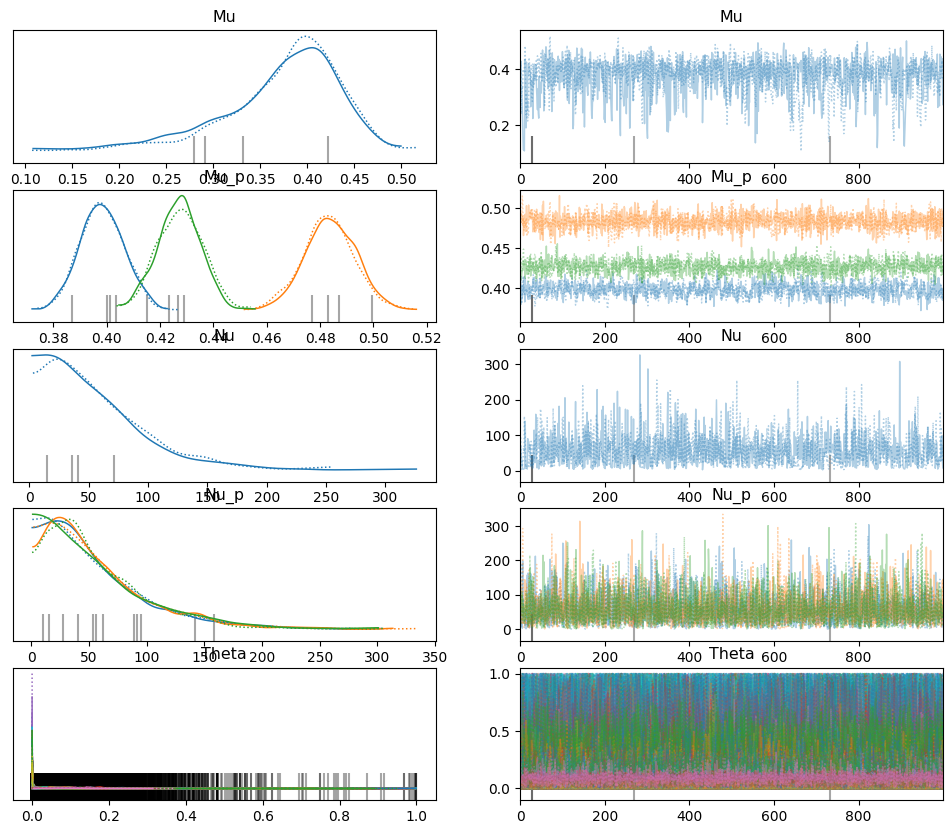

In [38]:
az.plot_trace(idata_newH)

In [39]:
az.rhat(idata_newH)

<xarray.Dataset> Size: 40kB
Dimensions:      (pos: 3, Theta_dim_0: 2517)
Coordinates:
  * pos          (pos) <U2 24B 'DF' 'FW' 'MF'
  * Theta_dim_0  (Theta_dim_0) int64 20kB 0 1 2 3 4 ... 2512 2513 2514 2515 2516
Data variables:
    Mu           float64 8B 1.008
    Mu_p         (pos) float64 24B 1.001 1.001 1.001
    Nu           float64 8B 1.004
    Nu_p         (pos) float64 24B 1.001 0.9997 1.002
    Theta        (Theta_dim_0) float64 20kB 1.002 1.001 0.9996 ... 1.002 1.0

Which model was easier for pymc to process?

*Pymc definitely had an easier time processing the second model because of less variation in GK- I let it sit for just a few minutes and it was done!*

What do we lose by dropping Gks from the data set? What do we gain?

*We lost this entire category of information about how our goalies generally do on their shooting, which is normally bad because it's important to keep our models as complete a set of information as possible, but it did make the overall outputs significantly cleaner because of such a high variation. It's not really better or worse this way, just different and we have to declare that.*